# Milesone Project 2: SkimLit

The purpose of this notebook is to to build an NLP model to make reading medical abstracs easier

## Confirm access to GPU

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-bbdd9403-184a-5c3f-f95e-ea5128584b0b)


## Get data

For the project, the dataset used will be PubMed 200k RCT, which can be downloaded from author's GitHub: https://github.com/Franck-Dernoncourt/pubmed-rct

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25 (from 1)
Receiving objects: 100% (39/39), 177.08 MiB | 12.60 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


In [3]:
# Check files present in PubMed 20k dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [4]:
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [5]:
# Check all the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

## Preprocess data

One of the best ways to become one with the data is to visualise

Let's write a function to read in all of the lines of a target text file

In [6]:
# Create a function to read the lines of a document
def get_lines(filename):
  """
  Reads filename (a text filename) and returns the lines of the text as a list

  Args:
    filename: a string containing the target filepath

  Returns:
    A list of strings with one string per line from the target filename.
  """
  with open(filename, "r") as f:
    return f.readlines()

In [7]:
# Reading the training lines
train_lines = get_lines(data_dir + "train.txt") # read the lines with the training file
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [8]:
len(train_lines)

210040

The data would be best represented in the following manner

```
 [{
    "line_number": 0,
    "target": "OBJECTIVE",
    "text": "Emotional eating is associated with overeating and the development of obesity .\n",
    "total_lines": 11
},
.....]
```

Let's write a function which turns each of our datasets into the above format so we can continue to prepare our data for modelling

In [9]:
def preprocess_text_with_line_numbers(filename):
  """Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list

    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line

  return abstract_samples

In [10]:
# Get data from file and process it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt") # dev is another name for validation data
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")

print(len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135
CPU times: user 852 ms, sys: 162 ms, total: 1.01 s
Wall time: 3.27 s


In [11]:
# Check some abstracts
train_samples[:10]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

Converting the preprocessed data into a Pandas DataFrame

In [12]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [13]:
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [14]:
# Distribution of lables in training data
train_df.target.value_counts()

,count
target,
METHODS,59353
RESULTS,57953
CONCLUSIONS,27168
BACKGROUND,21727
OBJECTIVE,13839


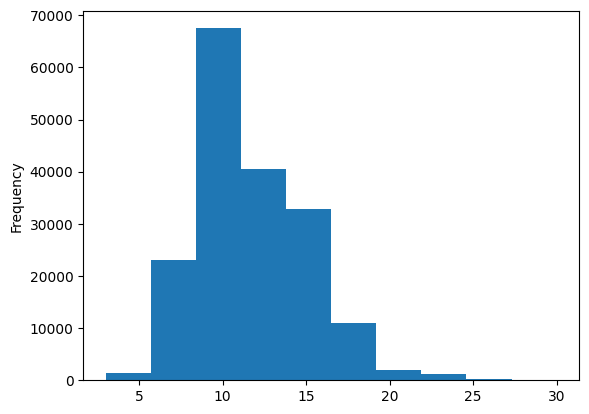

In [15]:
# Let's check the length of different lines
train_df.total_lines.plot.hist();

### Get lists of sentences

In [16]:
# Convert abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()

In [17]:
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [18]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make numeric labels (ML models require numeric labels)

In [19]:
# One hot encode the labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse_output= False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

In [20]:
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

### Label encode labels

In [21]:
# Extract labels and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

In [22]:
train_labels_encoded[:10]

array([3, 2, 2, 2, 2, 2, 4, 4, 4, 4])

In [23]:
# Get class names and number of classes from LabelEncoder
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

### Starting a series of modelling experiments

## Model 0: Baseline with Naive-Bayes

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


# Create a pipeline
model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),  # Step 1: TF-IDF vectorizer
    ("clf", MultinomialNB())       # Step 2: Classifier
])

# Fit the pipeline to the training data
model_0.fit(X = train_sentences,
            y = train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [25]:
# Evaluate baseline model on validation dataset
model_0.score(X = val_sentences,
                 y = val_labels_encoded)

0.7218323844829869

In [26]:
# Make prediction using baseline
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:10]

array([4, 1, 3, 2, 2, 2, 2, 2, 4, 4])

In [27]:
val_labels_encoded[:10]

array([0, 0, 3, 2, 2, 4, 4, 4, 4, 1])

### Download helper function script

In [28]:
!wget https://raw.githubusercontent.com/arrshsh/ML-and-DS/refs/heads/main/TensorFlow/helper_functions.py
from helper_functions import calculate_results

--2025-01-01 19:31:30--  https://raw.githubusercontent.com/arrshsh/ML-and-DS/refs/heads/main/TensorFlow/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10637 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.39K  --.-KB/s    in 0s      

2025-01-01 19:31:30 (24.5 MB/s) - ‘helper_functions.py’ saved [10637/10637]



In [29]:
# Calculate baseline results
baseline_results = calculate_results(y_true = val_labels_encoded,
                                     y_pred = baseline_preds)
baseline_results

y_true device: CPU
y_pred device: CPU


{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Preparing our data (the text ) for deep sequence models

Before getting into deeper model, we need to create vectorization and embedding layers

In [30]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [31]:
# How long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
max_sent_len = np.max(sent_lens)
min_sent_len = np.min(sent_lens)

avg_sent_len, max_sent_len, min_sent_len

(26.338269273494777, 296, 1)

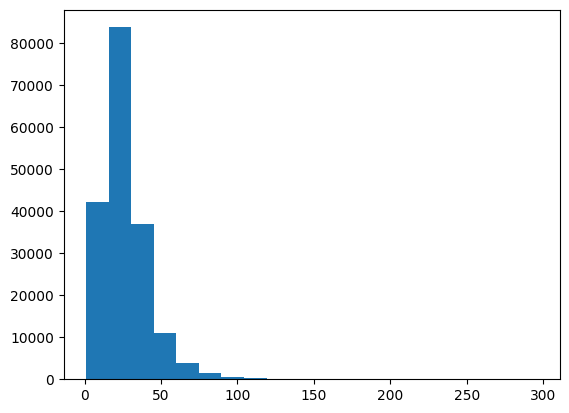

In [32]:
# what does the distribution look like?
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins = 20);

In [33]:
# How long of a sentence covers 95% of the data?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

### Create text vectorizer layer

This layer maps the texts from words to numbers

In [34]:
# How many words are in our vocab
max_tokens = 68000

In [35]:
# Create the text vectorizer
from tensorflow.keras.layers import TextVectorization

text_vectorizer = TextVectorization(max_tokens= max_tokens, # number of words in vocabulary
                                    output_sequence_length = output_seq_len) # desired output length of vectorized sequences

In [36]:
# Adapt text vectorizer to train sentences
text_vectorizer.adapt(train_sentences)

In [37]:
# Test out text vectorizer on random sentences
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized version {text_vectorizer([target_sentence])}")

Text:
( @ ) hemodynamic parameters : in control group , arterial partial pressure of oxygen , oxygen saturation and left ventricular ejection fraction , pulmonary systolic pression were ( @ @ ) % to ( @ @ ) % , ( @ @ ) to ( @ @ ) mmhg ( @ mmhg = @ kpa ) , @ @ to @ @ and ( @ @ ) to ( @ @ ) mmhg before and after treatment , which showed remarkable decreased trends ( p < @ ) .

Length of text: 90

Vectorized version [[ 1273   315     5    35    13   678  1049   200     4   617   617  2220
      3   601   773  1396  1015   562   680 29105     9     6     6   694
    694  4642     6     3     6   694   129     3    21    19   126   147
   6603   212  2961    14     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [38]:
# How many words in our training vocab?
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Most common words in vocab: {rct_20k_text_vocab[:10]}")
print(f"Least common words in vocab: {rct_20k_text_vocab[-10:]}")

Number of words in vocab: 64841
Most common words in vocab: ['', '[UNK]', 'the', 'and', 'of', 'in', 'to', 'with', 'a', 'were']
Least common words in vocab: ['aarm', 'aaqol', 'aaq', 'aanhui', 'aana', 'aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [39]:
# Get config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': {'module': 'keras',
  'class_name': 'DTypePolicy',
  'config': {'name': 'float32'},
  'registered_name': None},
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

### Create custom text embeddding

In [40]:
token_embed = layers.Embedding(input_dim= len(rct_20k_text_vocab),
                               output_dim = 128,
                               mask_zero = True,
                               name= "token_embedding")

In [41]:
# Show an example embedding
print(f"\nSentence before vectorization: {target_sentence}")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"\nSentence after vectorization:\n {vectorized_sentence}")
embedded_sentence = token_embed(vectorized_sentence)
print(f"\nEmbedded version:\n {embedded_sentence}")
print(f"\nEmbedded version shape:\n {embedded_sentence.shape}")


Sentence before vectorization: ( @ ) hemodynamic parameters : in control group , arterial partial pressure of oxygen , oxygen saturation and left ventricular ejection fraction , pulmonary systolic pression were ( @ @ ) % to ( @ @ ) % , ( @ @ ) to ( @ @ ) mmhg ( @ mmhg = @ kpa ) , @ @ to @ @ and ( @ @ ) to ( @ @ ) mmhg before and after treatment , which showed remarkable decreased trends ( p < @ ) .

Sentence after vectorization:
 [[ 1273   315     5    35    13   678  1049   200     4   617   617  2220
      3   601   773  1396  1015   562   680 29105     9     6     6   694
    694  4642     6     3     6   694   129     3    21    19   126   147
   6603   212  2961    14     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Embedded version:
 [[[ 0.02379179 -0.03411961  0.01969031 ... -0.03064852  0.00171966
    0.02148489]
  [-0.00315627  0.03425597  0.01832953 ... -0.01694335 -0.0325532
    0.03534642]
  [-0.00319742 -0.02763836  0.03814063

## Creating datasets (making sure our data loads as fast as possible)


This will be done using TensorFlow tf.data API

In [42]:
# Turn our data into TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [43]:
# Take the TensorSliceDataset's and turn them into prefetched datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [44]:
## Model 1: Cov1D with token embeddings
inputs = layers.Input(shape = (1, ), dtype = tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)
x = layers.Conv1D(filters = 64,
                  kernel_size = 5,
                  padding = "same",
                  activation = "relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation = "softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss= "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

model_1.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization                   │ (None, 55)                  │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ token_embedding (Embedding)          │ (None, 55, 128)             │       8,299,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 55, 64)              │          41,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 64)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,340,997 (31.82 MB)

 Trainable params: 8,340,997 (31.82 MB)

 Non-trainable params: 0 (0.00 B)

In [45]:
history_model_1 = model_1.fit(
    train_dataset,
    steps_per_epoch=int(0.1 * len(train_dataset)),
    epochs=3,
    validation_data=valid_dataset,
    validation_steps=int(0.1 * len(valid_dataset))
) # only training and validating on 10% of the data

Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 51s 88ms/step - accuracy: 0.5210 - loss: 1.1634 - val_accuracy: 0.7414 - val_loss: 0.6937
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 49s 87ms/step - accuracy: 0.7468 - loss: 0.6850 - val_accuracy: 0.7683 - val_loss: 0.6325
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 49s 87ms/step - accuracy: 0.7680 - loss: 0.6242 - val_accuracy: 0.7892 - val_loss: 0.5925


In [46]:
# Evaluate on the whole dataset
model_1.evaluate(test_dataset)

942/942 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.7799 - loss: 0.6145


[0.6143795251846313, 0.7824456691741943]

In [47]:
# Make predictions
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs

945/945 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step


array([[4.5024544e-01, 1.3822418e-01, 5.8537170e-02, 3.1975058e-01,
        3.3242680e-02],
       [4.1561517e-01, 3.2121700e-01, 9.6339975e-03, 2.4459828e-01,
        8.9355102e-03],
       [1.8447161e-01, 7.3636486e-03, 2.7548741e-03, 8.0536675e-01,
        4.3140910e-05],
       ...,
       [7.0297906e-06, 8.0972182e-04, 6.9857558e-04, 4.8234151e-06,
        9.9847990e-01],
       [4.5641448e-02, 4.4028914e-01, 8.6181097e-02, 5.4136656e-02,
        3.7375158e-01],
       [1.8585740e-01, 6.4192498e-01, 5.1889468e-02, 6.0723800e-02,
        5.9604421e-02]], dtype=float32)

In [48]:
model_1_pred_probs.shape

(30212, 5)

In [49]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis = 1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [50]:
class_names

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

In [51]:
# Calculate the results for model_1
model_1_results = calculate_results(y_true = val_labels_encoded,
                  y_pred = model_1_preds)
model_1_results

y_true device: CPU
y_pred device: CPU


{'accuracy': 78.64424731894611,
 'precision': 0.7831798923146778,
 'recall': 0.7864424731894611,
 'f1': 0.7841747075085448}

In [52]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Model 2: Feature extraction with pretrained token embeddings


The paper uses GloVe embeddings, but we will go with the later created USE pretrained embeddings.

In [53]:
class UniversalSentenceEncoder(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.encoder = hub.KerasLayer(
            "https://tfhub.dev/google/universal-sentence-encoder/4",
            trainable=False,
            name="universal_sentence_encoder"
        )

    def call(self, inputs):
        return self.encoder(inputs)

    def get_config(self):
        return super().get_config()

### Building and fitting an NLP feature extraction model using pretrained embedding

In [54]:
import tensorflow_hub as hub

def create_use_model(num_classes):
    # Define model
    inputs = layers.Input(shape=(), dtype=tf.string)
    embedding = UniversalSentenceEncoder()(inputs)
    x = layers.Dense(128, activation="relu")(embedding)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    # Create and compile model
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="model_2_USE_feature_extractor")
    model.compile(
        loss="categorical_crossentropy",
        optimizer=tf.keras.optimizers.Adam(),
        metrics=["accuracy"]
    )

    # # Print detailed layer information
    # print("\nDetailed layer information:")
    # for layer in model.layers:
    #     print(f"\nLayer: {layer.name}")
    #     # print(f"Input shape: {layer.input_shape}")
    #     print(f"Output shape: {layer.output_shape}")
    #     weights = layer.get_weights()
    #     if weights:
    #         print(f"Number of weights in layer: {sum(w.size for w in weights)}")

    return model

In [55]:

# Create the model
model_2 = create_use_model(num_classes)

In [56]:
model_2.summary()

Model: "model_2_USE_feature_extractor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None)                      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ universal_sentence_encoder           │ (None, 512)                 │               0 │
│ (UniversalSentenceEncoder)           │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 66,309 (259.02 KB)

 Trainable params: 66,309 (259.02 KB)

 Non-trainable params: 0 (0.00 B)

In [57]:
# Fit model_2 to data
history_model_2 = model_2.fit(train_dataset,
                              epochs  =3,
                              steps_per_epoch = int(0.1 * len(train_dataset)),
                              validation_data = valid_dataset,
                              validation_steps = int(0.1 * len(valid_dataset)))

Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.5773 - loss: 1.0897 - val_accuracy: 0.6922 - val_loss: 0.7947
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.7026 - loss: 0.7708 - val_accuracy: 0.7091 - val_loss: 0.7553
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.7123 - loss: 0.7547 - val_accuracy: 0.7197 - val_loss: 0.7270


In [58]:
#  Evaluate on the whole validation dataset
model_2.evaluate(valid_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.7144 - loss: 0.7389


[0.740722119808197, 0.7142195105552673]

In [59]:
# Make predictions with feature extraction model
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs[:10]

945/945 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step


array([[4.4081047e-01, 3.6111459e-01, 1.6448501e-03, 1.8920974e-01,
        7.2203469e-03],
       [3.4162092e-01, 5.1834518e-01, 2.1879692e-03, 1.3510582e-01,
        2.7401075e-03],
       [2.6177573e-01, 1.2828486e-01, 1.3273316e-02, 5.6465095e-01,
        3.2015014e-02],
       [1.5250651e-02, 4.9127627e-02, 7.9795337e-01, 9.5809111e-03,
        1.2808739e-01],
       [3.3363044e-02, 2.6147297e-01, 2.1039024e-01, 1.5468350e-02,
        4.7930530e-01],
       [1.0946476e-03, 2.2596787e-03, 7.0588231e-01, 1.0428105e-04,
        2.9065916e-01],
       [2.2688389e-03, 3.6144897e-03, 6.8786734e-01, 1.2315750e-03,
        3.0501771e-01],
       [4.9288571e-03, 2.1370426e-02, 4.1283223e-01, 1.0827371e-03,
        5.5978584e-01],
       [1.0186770e-03, 9.0143206e-03, 2.1552699e-02, 1.2491380e-03,
        9.6716517e-01],
       [1.3843097e-01, 7.0043808e-01, 2.0957356e-02, 7.3989168e-02,
        6.6184469e-02]], dtype=float32)

In [60]:
# Convert the prediction probabilities found with feature extraction model to labels
model_2_preds = tf.argmax(model_2_pred_probs, axis =1)
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 1, 3, 2, 4, 2, 2, 4, 4, 1])>

In [61]:
# Calculate results of model_2
model_2_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_2_preds)
model_2_results

y_true device: CPU
y_pred device: CPU


{'accuracy': 71.42195154243348,
 'precision': 0.7144654537154898,
 'recall': 0.7142195154243347,
 'f1': 0.7112001575082806}

In [62]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [63]:
model_1_results

{'accuracy': 78.64424731894611,
 'precision': 0.7831798923146778,
 'recall': 0.7864424731894611,
 'f1': 0.7841747075085448}

## Model 3: Conv1D with character embeddings

The paper which we are replicating states that they used a combination of token and character-levelembedding.

We have done token-level embeddings before, but we'll need to follow similar steps if we want to use character-level embeddings.

### Creating a character-level tokenizer

In [64]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [65]:
# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

# # Test splitting non-character-level sequence into characters
# split_chars(random_training_sentence)

In [66]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
print(train_chars[0])

t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .


In [67]:
# What's the average character length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len


149.3662574983337

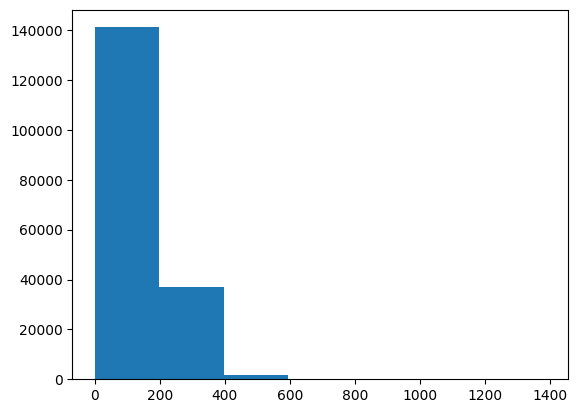

In [68]:
# Check the distribution of our sequences at character-level
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=7);

In [69]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [70]:
# Get all keyboard characters for char-level embedding
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [71]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # num characters in alphabet + space + OOV token
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")

In [72]:
# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)

In [73]:
# Check character vocabulary characteristics
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [74]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
c o n c o m i t a n t   l i p o s u c t i o n   a t   t h e   t i m e   o f   a b d o m i n o p l a s t y   i n c r e a s e s   t h e   r i s k   o f   s e r o m a   f o r m a t i o n   c o m p a r e d   t o   p a t i e n t s   h a v i n g   a b d o m i n o p l a s t y   a l o n e   .

Length of chars: 124

Vectorized chars:
[[11  7  6 11  7 15  4  3  5  6  3 12  4 14  7  9 16 11  3  4  7  6  5  3
   3 13  2  3  4 15  2  7 17  5 22 10  7 15  4  6  7 14 12  5  9  3 19  4
   6 11  8  2  5  9  2  9  3 13  2  8  4  9 23  7 17  9  2  8  7 15  5 17
   7  8 15  5  3  4  7  6 11  7 15 14  5  8  2 10  3  7 14  5  3  4  2  6
   3  9 13  5 21  4  6 18  5 22 10  7 15  4  6  7 14 12  5  9  3 19  5 12
   7  6  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 

### Creating a character-level embedding

In [75]:
# Create char embedding layer
char_embed = layers.Embedding(input_dim = len(char_vocab), # number of different characters
                              output_dim = 25, # This is the size of char embedding in the paper
                              mask_zero = True,
                              name = "char_embed")

In [76]:
# Test our character embedding layer
print(f"Charified text: \n {random_train_chars}")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding): \n{char_embed_example}\n")
print(f"Char embedding shape: {char_embed_example.shape}")

Charified text: 
 c o n c o m i t a n t   l i p o s u c t i o n   a t   t h e   t i m e   o f   a b d o m i n o p l a s t y   i n c r e a s e s   t h e   r i s k   o f   s e r o m a   f o r m a t i o n   c o m p a r e d   t o   p a t i e n t s   h a v i n g   a b d o m i n o p l a s t y   a l o n e   .
Embedded chars (after vectorization and embedding): 
[[[ 0.01444883 -0.04418791  0.03124067 ...  0.01340291  0.04109717
   -0.03609587]
  [-0.03229745 -0.0280555  -0.00681367 ...  0.04629525  0.00258921
   -0.01027597]
  [-0.02917355 -0.02674252 -0.04558178 ...  0.03507576  0.02963909
   -0.01503811]
  ...
  [-0.02985939 -0.02757847 -0.04716188 ... -0.02561067 -0.0497605
   -0.00705423]
  [-0.02985939 -0.02757847 -0.04716188 ... -0.02561067 -0.0497605
   -0.00705423]
  [-0.02985939 -0.02757847 -0.04716188 ... -0.02561067 -0.0497605
   -0.00705423]]]

Char embedding shape: (1, 290, 25)


### Building a Conv1D model to fit on character embeddings

In [77]:
# Make Conv1D on chars only
inputs = layers.Input(shape = (1,), dtype = tf.string)
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D (64,
                   kernel_size = 5,
                   padding = "same",
                   activation = "relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation = "softmax")(x)
model_3 = tf.keras.Model(inputs, outputs, name= "model_3_char_embeddings")

# Compile the model
model_3.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics  =["accuracy"])


model_3.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'conv1d_1' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "model_3_char_embeddings"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ char_vectorizer (TextVectorization)  │ (None, 290)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ char_embed (Embedding)               │ (None, 290, 25)             │             700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 290, 64)             │           8,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 64)                  │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,089 (35.50 KB)

 Trainable params: 9,089 (35.50 KB)

 Non-trainable params: 0 (0.00 B)

In [78]:
# Create char level datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [79]:
train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [80]:
# Fit the models on chars only
hostory_model_3 = model_3.fit(train_char_dataset,
                              steps_per_epoch = int(0.1 * len(train_char_dataset)),
                              epochs = 3,
                              validation_data = val_char_dataset,
                              validation_steps = int(0.1 * len(val_char_dataset)))

Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.4296 - loss: 1.3922 - val_accuracy: 0.5801 - val_loss: 1.0493
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.5752 - loss: 1.0402 - val_accuracy: 0.6323 - val_loss: 0.9494
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - accuracy: 0.6229 - loss: 0.9431 - val_accuracy: 0.6493 - val_loss: 0.8910


In [81]:
# Make predictions with character model only
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs[:10]

945/945 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step


array([[1.62538186e-01, 4.05237973e-01, 1.55978724e-01, 2.19499946e-01,
        5.67450598e-02],
       [1.40452966e-01, 7.64413953e-01, 7.26949144e-03, 6.46949783e-02,
        2.31685210e-02],
       [1.02579534e-01, 3.05060863e-01, 5.82668409e-02, 4.62333709e-01,
        7.17590302e-02],
       [6.47821045e-03, 1.30541855e-02, 9.06698942e-01, 8.60500149e-03,
        6.51636422e-02],
       [1.77735854e-02, 9.54927579e-02, 5.47018647e-01, 5.88730052e-02,
        2.80841947e-01],
       [4.78498230e-04, 1.02339440e-03, 8.39668870e-01, 4.04975377e-04,
        1.58424124e-01],
       [5.52014867e-03, 9.05210711e-03, 5.33602893e-01, 4.23989445e-03,
        4.47584957e-01],
       [1.83199853e-01, 4.10397619e-01, 5.78155965e-02, 2.53961951e-01,
        9.46249366e-02],
       [3.31636588e-03, 1.78835839e-02, 9.58882272e-02, 4.08648513e-03,
        8.78825426e-01],
       [7.53445253e-02, 4.05404449e-01, 1.29040495e-01, 1.59852162e-01,
        2.30358303e-01]], dtype=float32)

In [82]:
# Convert pred probs to labels
model_3_preds = tf.argmax(model_3_pred_probs, axis =1)

In [83]:
# Calcualte the results
model_3_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_3_preds)
model_3_results

y_true device: CPU
y_pred device: CPU


{'accuracy': 65.0801006222693,
 'precision': 0.6449832264004817,
 'recall': 0.650801006222693,
 'f1': 0.6399124175268919}

In [84]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Model 4: Combining pretrained token embeddings + character embedding (hybrid embedding layer)

1. Create a token-level embedding model (similar to `model_1`)
2. Create a character-level embedding mdoel (similar to `model_3` with some slight modifications)
3. Combine 1 & 2 with a concatenate (`layers.Concatenate`)
4. Build a series of output layers on top of 3
5. Construct a model which takes token and character-level sequences as input and produces sequence label probabilities as output

In [85]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = UniversalSentenceEncoder()(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs, outputs=token_outputs)

# 2. Set up char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs, outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (create a hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_concat")([token_model.output, char_model.output])

# 4. Create output layers - adding in Droptout
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation = "relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
combined_output = layers.Dense(num_classes, activation = "softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs = [token_model.input, char_model.input],
                         outputs = combined_output,
                         name = "model_4_token_and_Char_embeddings")

In [86]:
# Get a summary of the model
model_4.summary()

Model: "model_4_token_and_Char_embeddings"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ char_input (InputLayer)   │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_input (InputLayer)  │ (None)                 │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ char_vectorizer           │ (None, 290)            │              0 │ char_input[0][0]       │
│ (TextVectorization)       │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ universal_sentence_encod… │ (None, 512)            │              0 │ token_input[0][0]      │
│ (UniversalSentenceEncode… │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ char_embed (Embedding)    │ (None, 290, 25)        │            700 │ char_vectorizer[1][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_2 (NotEqual)    │ (None, 290)            │              0 │ char_vectorizer[1][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 128)            │         65,664 │ universal_sentence_en… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 48)             │          9,600 │ char_embed[1][0],      │
│ (Bidirectional)           │                        │                │ not_equal_2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_char_concat         │ (None, 176)            │              0 │ dense_4[0][0],         │
│ (Concatenate)             │                        │                │ bidirectional[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 176)            │              0 │ token_char_concat[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 128)            │         22,656 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128)            │              0 │ dense_5[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 5)              │            645 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 99,265 (387.75 KB)

 Trainable params: 99,265 (387.75 KB)

 Non-trainable params: 0 (0.00 B)

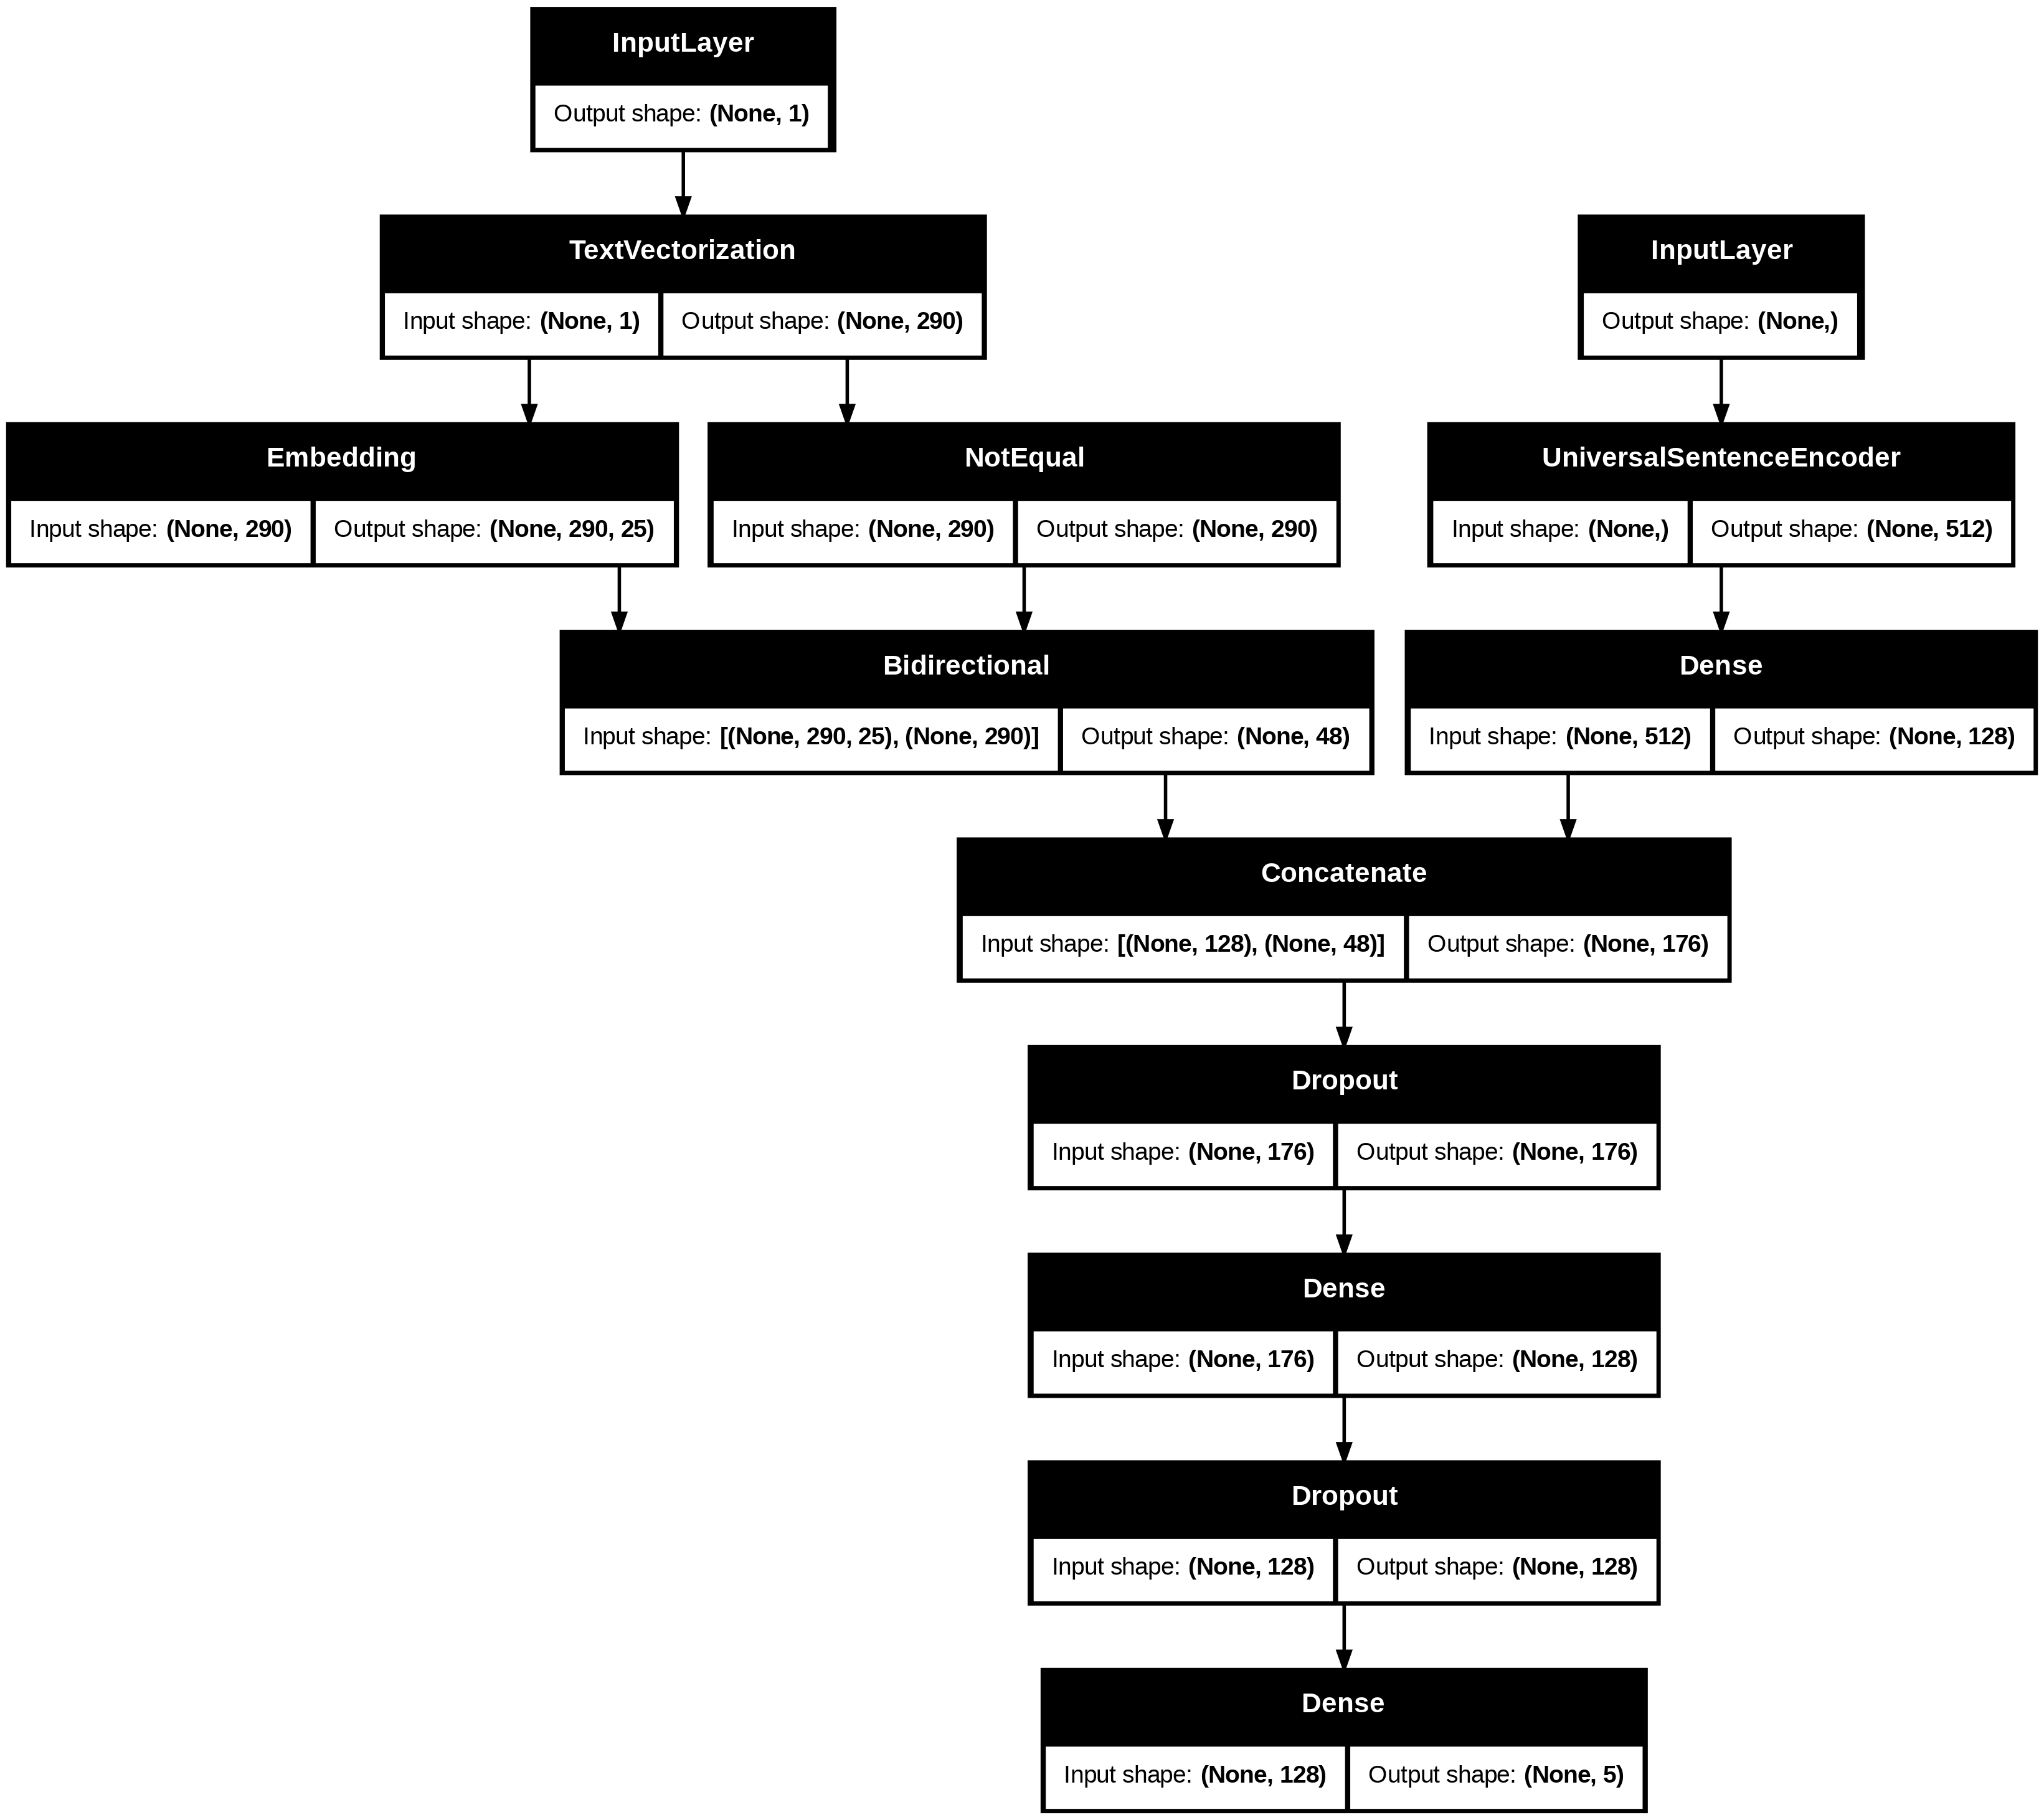

In [87]:
# Plot hybrid token and character model
from keras.utils import plot_model
plot_model(model_4, show_shapes = True)

In [88]:
# Compile token char model
model_4.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

### Combining token and character data into a tf.data Dataset

In [89]:
# combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip(train_char_token_data, train_char_token_labels) # combine data and labels

# Prefetch and batch train dataset
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [90]:
# Repeat the above steps for validation steps
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars)) # make data
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot) # make labels
val_char_token_dataset = tf.data.Dataset.zip(val_char_token_data, val_char_token_labels) # combine data and labels

# Prefetch and batch val dataset
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [91]:
# Check out the training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

**The order of char and token data in the final dataset should be the same as the order in which the concatenate layer expects the inputs**

### Fitting a model on token and character-level sequences

In [92]:
# Fit the model on tokens and chars
history_model_4 = model_4.fit(train_char_token_dataset,
                              steps_per_epoch = int(0.1 * len(train_char_token_dataset)),
                              epochs =3,
                              validation_data = val_char_token_dataset,
                              validation_steps = int(0.1 * len(val_char_token_dataset)))

Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 185s 316ms/step - accuracy: 0.5267 - loss: 1.1499 - val_accuracy: 0.7021 - val_loss: 0.7736
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 178s 316ms/step - accuracy: 0.6873 - loss: 0.8174 - val_accuracy: 0.7261 - val_loss: 0.7163
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 176s 313ms/step - accuracy: 0.7011 - loss: 0.7802 - val_accuracy: 0.7314 - val_loss: 0.6841


In [93]:
model_1_results

{'accuracy': 78.64424731894611,
 'precision': 0.7831798923146778,
 'recall': 0.7864424731894611,
 'f1': 0.7841747075085448}

In [94]:
# Evaluate on the whole dataset
model_4.evaluate(val_char_token_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 66s 70ms/step - accuracy: 0.7343 - loss: 0.6961


[0.6964879035949707, 0.7343770861625671]

In [95]:
# Make predictions using model_4
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs[:10]

945/945 ━━━━━━━━━━━━━━━━━━━━ 66s 69ms/step


array([[4.1329953e-01, 3.6227682e-01, 4.4461158e-03, 2.0849571e-01,
        1.1481842e-02],
       [2.9899603e-01, 5.2387816e-01, 2.6113731e-03, 1.7148326e-01,
        3.0311008e-03],
       [3.0120414e-01, 1.4409015e-01, 5.7211090e-02, 4.5452654e-01,
        4.2967930e-02],
       [1.2271296e-02, 1.6778128e-02, 8.7055284e-01, 5.8003543e-03,
        9.4597384e-02],
       [3.9111629e-02, 1.2185360e-01, 4.9986422e-01, 1.6123239e-02,
        3.2304731e-01],
       [6.8552815e-04, 1.8620410e-03, 7.2616464e-01, 1.9357575e-04,
        2.7109420e-01],
       [2.5033236e-03, 1.3941320e-02, 5.1384711e-01, 8.5983670e-04,
        4.6884844e-01],
       [2.5103237e-03, 2.4058050e-02, 4.1813523e-01, 8.3841890e-04,
        5.5445790e-01],
       [3.9439398e-04, 1.2209596e-02, 2.6743898e-02, 1.4725162e-04,
        9.6050483e-01],
       [2.8217921e-01, 4.2771688e-01, 3.6509462e-02, 1.8862432e-01,
        6.4970188e-02]], dtype=float32)

In [96]:
# Converts probability to labels
model_4_preds = tf.argmax(model_4_pred_probs, axis = 1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [97]:
# Calculate the results for model_4
model_4_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_4_preds)
model_4_results

y_true device: CPU
y_pred device: CPU


{'accuracy': 73.4377068714418,
 'precision': 0.7360415200728119,
 'recall': 0.7343770687144181,
 'f1': 0.7309926390547441}

In [98]:
model_1_results

{'accuracy': 78.64424731894611,
 'precision': 0.7831798923146778,
 'recall': 0.7864424731894611,
 'f1': 0.7841747075085448}

## Model 5: Transfer Learning with pretrained token embeddings + character embeddings + positional embeddings

In [99]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


> Any engineered feature used to train a model needs to be available at the test time. In this case, line numbers and total number of lines are available during testing.

### Create positional embeddings

In [100]:
# How many different line numbers are there?
train_df["line_number"].value_counts()

,count
line_number,
0,15000
1,15000
2,15000
3,15000
4,14992
5,14949
6,14758
7,14279
8,13346


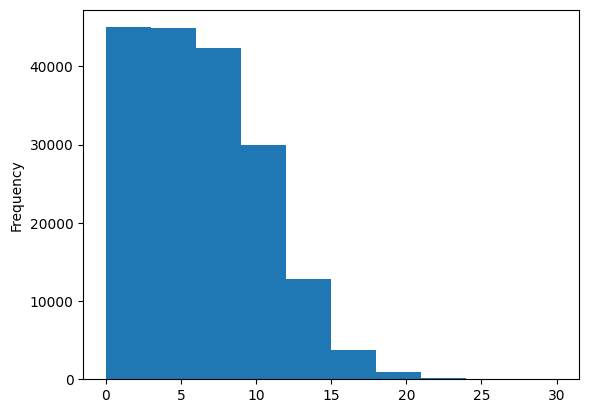

In [101]:
# Check the distribution of "line_number" column
train_df["line_number"].plot.hist();

In [102]:
# Use tensorflow to create on-hot-encoded tensors of our line numbers
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(),
                                        depth = 15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(),
                                      depth = 15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(),
                                      depth = 15)
train_line_numbers_one_hot[:10], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>,
 TensorShape([180040, 15]))

Now that line numbers feature is one-hot-encoded, let us one-hot-encode total lines feature

In [103]:
# How many different numbers of total lines are there?
train_df["total_lines"].value_counts()

,count
total_lines,
11,24468
10,23639
12,22113
9,19400
13,18438
14,14610
8,12285
15,10768
7,7464


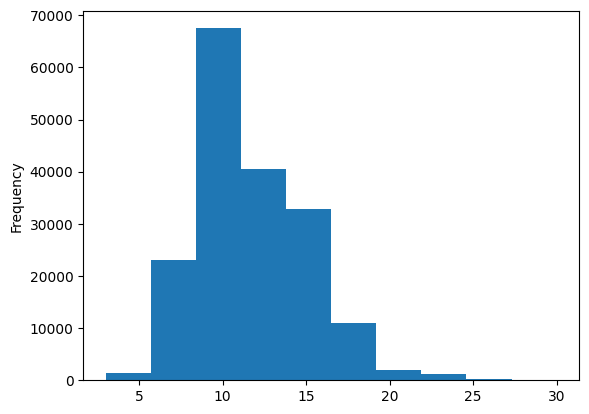

In [104]:
# Check the distribution
train_df["total_lines"].plot.hist();

In [107]:
# Check what length constitutes 98% of the data
np.percentile(train_df["total_lines"], 98)

20.0

In [109]:
# Use tensorFlow to create one-hot-encoded tensors of our "total lines" features
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth = 20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth = 20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth = 20)
train_total_lines_one_hot[:10], train_total_lines_one_hot.shape

(<tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0

### Building a tribid embedding model

1. Create a token-level model
2. Create a character-level model
3. Create a model for "line_number" feature
4. Create a model for "total_lines" feature
5. Combine the outputs of 1 & 2 using tf.keras.Concatenate
6. Combine the outputs of 3, 4, 5 using tf.keras.Concatenate
7. Create an output layer to accept the tribried embedding and output label probabilities
8. Combine the inputs of 1, 2, 3, 4 and outputs of 7 into a tf.keras.Model


In [113]:
# 1. Token inputs
token_inputs = layers.Input(shape = [], dtype = tf.string, name = "token_inputs")
token_embeddings = UniversalSentenceEncoder()(token_inputs)
token_outputs = layers.Dense(128, activation = "relu")(token_embeddings)
token_model = tf.keras.Model(inputs = token_inputs,
                             outputs = token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape = (1,), dtype = tf.string, name = "char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs = char_inputs,
                            outputs = char_bi_lstm,
                            name = "char_model")

# 3. Line number mdoel
line_number_inputs = layers.Input(shape = (15,), dtype = tf.float32, name = "line_number_inputs")
x = layers.Dense(32, activation = "relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs = line_number_inputs,
                                   outputs = x)

# 4. Total lines model
total_lines_inputs = layers.Input(shape = (20,), dtype = tf.float32, name = "total_lines_input")
y = layers.Dense(32, activation = "relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs = total_lines_inputs,
                                   outputs = y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name = "char_token_hybrid")([token_model.output, char_model.output])

z = layers.Dense(256, activation = "relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embeddings with combined token and char embeddings
tribid_embeddings = layers.Concatenate(name = "tribid_embeddings")([line_number_model.output, total_lines_model.output, z])

# 7. Create output layer
output_layer = layers.Dense(num_classes, activation= "softmax", name = "output_layer")(tribid_embeddings)

# 8. Put together the model with all kind of inputs
model_5 = tf.keras.Model(inputs = [line_number_model.input,
                                   total_lines_model.input,
                                   token_model.input,
                                   char_model.input],
                         outputs = output_layer,
                         name = "model_5_tribrid_embedding_model")

In [114]:
# Get a summary of our tribrid embedding model
model_5.summary()

Model: "model_5_tribrid_embedding_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ char_inputs (InputLayer)  │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_inputs (InputLayer) │ (None)                 │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ char_vectorizer           │ (None, 290)            │              0 │ char_inputs[0][0]      │
│ (TextVectorization)       │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ universal_sentence_encod… │ (None, 512)            │              0 │ token_inputs[0][0]     │
│ (UniversalSentenceEncode… │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ char_embed (Embedding)    │ (None, 290, 25)        │            700 │ char_vectorizer[4][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_5 (NotEqual)    │ (None, 290)            │              0 │ char_vectorizer[4][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_15 (Dense)          │ (None, 128)            │         65,664 │ universal_sentence_en… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_3           │ (None, 48)             │          9,600 │ char_embed[4][0],      │
│ (Bidirectional)           │                        │                │ not_equal_5[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ char_token_hybrid         │ (None, 176)            │              0 │ dense_15[0][0],        │
│ (Concatenate)             │                        │                │ bidirectional_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ line_number_inputs        │ (None, 15)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ total_lines_input         │ (None, 20)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_18 (Dense)          │ (None, 256)            │         45,312 │ char_token_hybrid[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_16 (Dense)          │ (None, 32)             │            512 │ line_number_inputs[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_17 (Dense)          │ (None, 32)             │            672 │ total_lines_input[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 256)            │              0 │ dense_18[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ tribid_embeddings         │ (None, 320)            │              0 │ dense_16[0][0],        │
│ (Concatenate)             │                        │                │ dense_17[0][0],        │
│                      

 Total params: 124,065 (484.63 KB)

 Trainable params: 124,065 (484.63 KB)

 Non-trainable params: 0 (0.00 B)

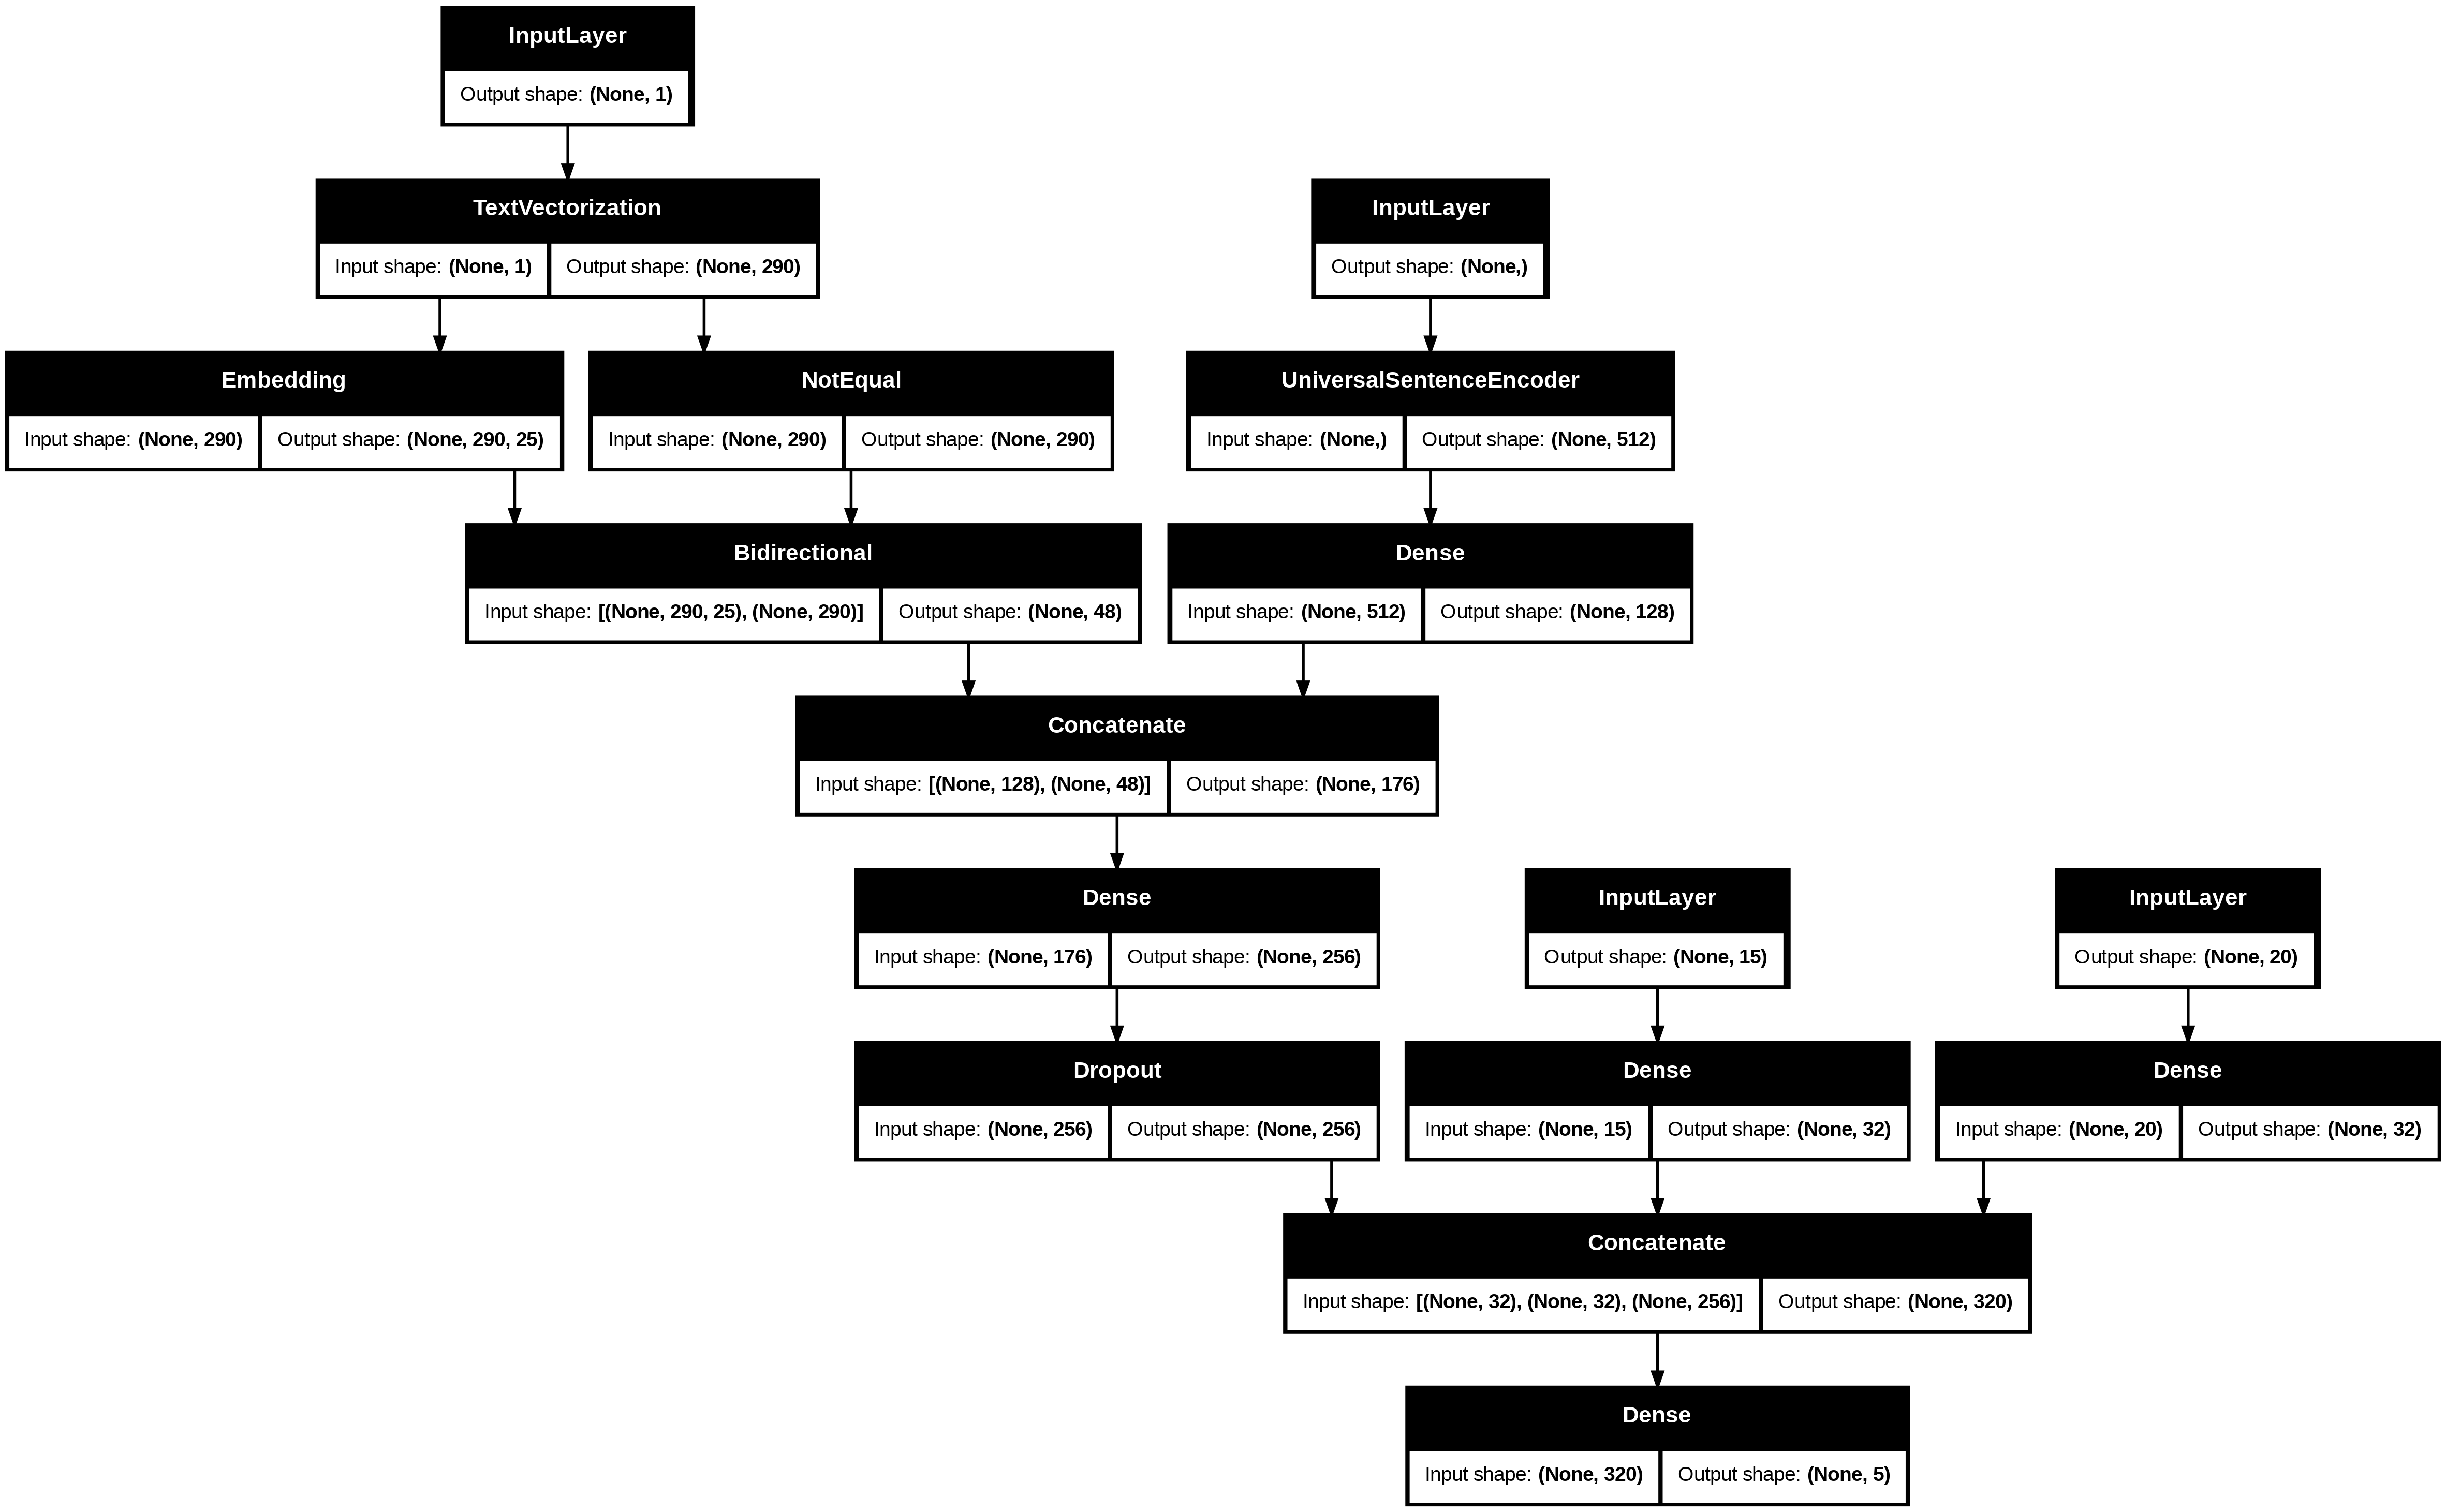

In [116]:
# Plot model_5
from keras.utils import plot_model
plot_model(model_5, show_shapes= True)

What is label smoothing?

For example, if our model gets too confident with the prediction of a particular label, then the overall output might look something like this:

`[0.0, 0.0, 0.0, 1, 0.0]`

what label smoothing does is that it assigns some value from the highest pred prob to other classes, in turn improving the generalisation. Hence, prediction probability for the same might look something like this:
`[0.01, 0.01, 0.01, 0.96, 0.01]`

In [118]:
# Compile token, char and positional embedding model
model_5.compile(loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # helps to prevent overfitting
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

### Create tribid embedding datasets usgin tf.data

In [122]:
# Create training and validation datasets (with all four kind of input data)
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, train_total_lines_one_hot, train_sentences, train_chars))

train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)

train_char_token_pos_dataset = tf.data.Dataset.zip(train_char_token_pos_data, train_char_token_labels)

train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Do the same as above for validation data
val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot, val_total_lines_one_hot, val_sentences, val_chars))

val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)

val_char_token_pos_dataset = tf.data.Dataset.zip(val_char_token_pos_data, val_char_token_labels)

val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [123]:
# Check input shapes
train_char_token_pos_dataset, val_char_token_pos_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fitting, evaluating and making predictions with our tribid model

In [124]:
history_model_5 = model_5.fit(train_char_token_pos_dataset,
                              steps_per_epoch = int(0.1 * len(train_char_token_pos_dataset)),
                              epochs = 3,
                              validation_data = val_char_token_pos_dataset,
                              validation_steps = int(0.1 * len(val_char_token_pos_dataset)))

Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 272s 465ms/step - accuracy: 0.6219 - loss: 1.2298 - val_accuracy: 0.8039 - val_loss: 0.9864
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 184s 328ms/step - accuracy: 0.8098 - loss: 0.9725 - val_accuracy: 0.8311 - val_loss: 0.9413
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 258s 459ms/step - accuracy: 0.8155 - loss: 0.9575 - val_accuracy: 0.8354 - val_loss: 0.9362


In [125]:
# Make predictions with char token pos model
model_5_pred_probs = model_5.predict(val_char_token_pos_dataset)
model_5_pred_probs[:10]

945/945 ━━━━━━━━━━━━━━━━━━━━ 71s 74ms/step


array([[0.47410068, 0.11537814, 0.00930115, 0.3876957 , 0.01352421],
       [0.52625126, 0.10553679, 0.03811215, 0.32183278, 0.00826698],
       [0.29559538, 0.09565835, 0.11564072, 0.43554378, 0.05756181],
       [0.04328716, 0.07649647, 0.7109104 , 0.04217112, 0.12713492],
       [0.05198058, 0.06422901, 0.68311894, 0.05224675, 0.1484247 ],
       [0.01399654, 0.04553828, 0.26072243, 0.01736938, 0.6623733 ],
       [0.01991791, 0.07520721, 0.24660076, 0.02634395, 0.6319301 ],
       [0.0148946 , 0.09062481, 0.19643687, 0.01889945, 0.67914426],
       [0.01906754, 0.05964605, 0.03473743, 0.02446245, 0.86208653],
       [0.04680168, 0.7199391 , 0.03085034, 0.04674567, 0.15566313]],
      dtype=float32)

In [126]:
# Convert pred probs to labels
model_5_preds = tf.argmax(model_5_pred_probs, axis = 1)
model_5_preds[:10]

<tf.Tensor: shape=(0,), dtype=int64, numpy=array([], dtype=int64)>

In [127]:
# Calculate model 5 results
model_5_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_5_preds)
model_5_results

y_true device: CPU
y_pred device: CPU


{'accuracy': 83.2152786972064,
 'precision': 0.8310254919267808,
 'recall': 0.8321527869720641,
 'f1': 0.8314643562455375}

In [128]:
model_4_results

{'accuracy': 73.4377068714418,
 'precision': 0.7360415200728119,
 'recall': 0.7343770687144181,
 'f1': 0.7309926390547441}

## Compare model results

In [130]:
# Combine model results into a dataframe
all_model_results = pd.DataFrame({"model_0_baseline": baseline_results,
                                  "model_1_custom_token_embedding": model_1_results,
                                  "model_2_token_embedding": model_2_results,
                                  "model_3_custom_char_embedding": model_3_results,
                                  "model_4_hybrid_char_token_embedding": model_4_results,
                                  "model_5_pos_char_token_embedding": model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
model_0_baseline,72.183238,0.718647,0.721832,0.698925
model_1_custom_token_embedding,78.644247,0.783180,0.786442,0.784175
model_2_token_embedding,71.421952,0.714465,0.714220,0.711200
model_3_custom_char_embedding,65.080101,0.644983,0.650801,0.639912
model_4_hybrid_char_token_embedding,73.437707,0.736042,0.734377,0.730993
model_5_pos_char_token_embedding,83.215279,0.831025,0.832153,0.831464


In [131]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

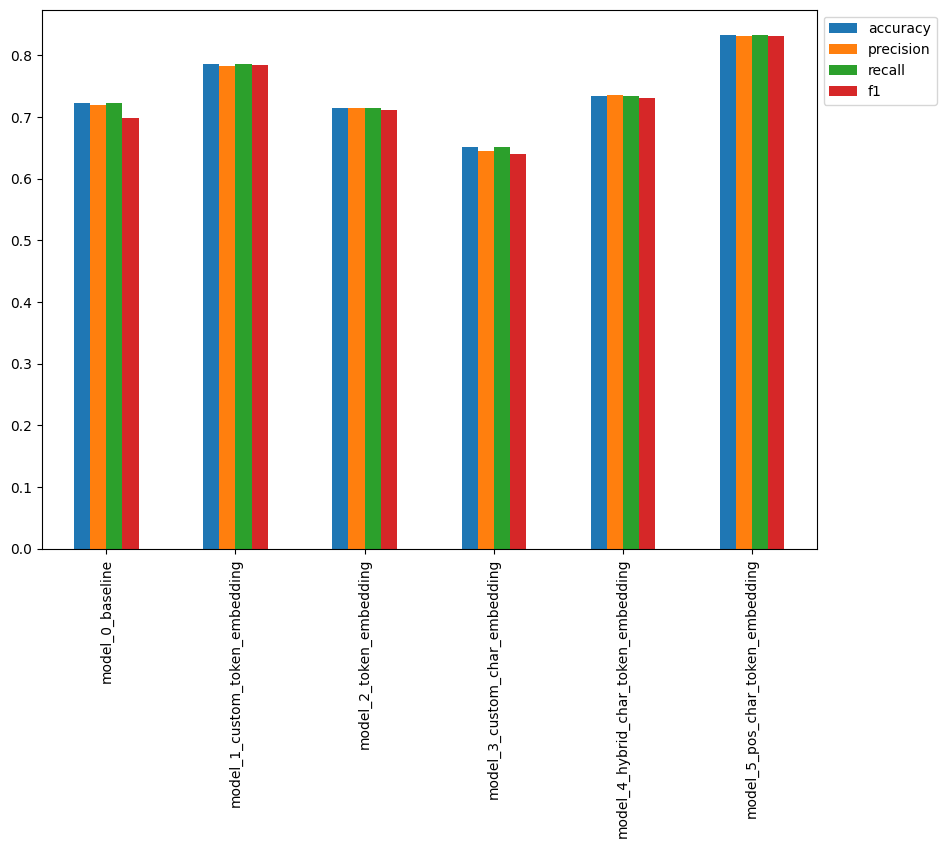

In [132]:
# Plot and compare all model results
all_model_results.plot(kind = "bar", figsize = (10,7)).legend(bbox_to_anchor = (1.0, 1.0));

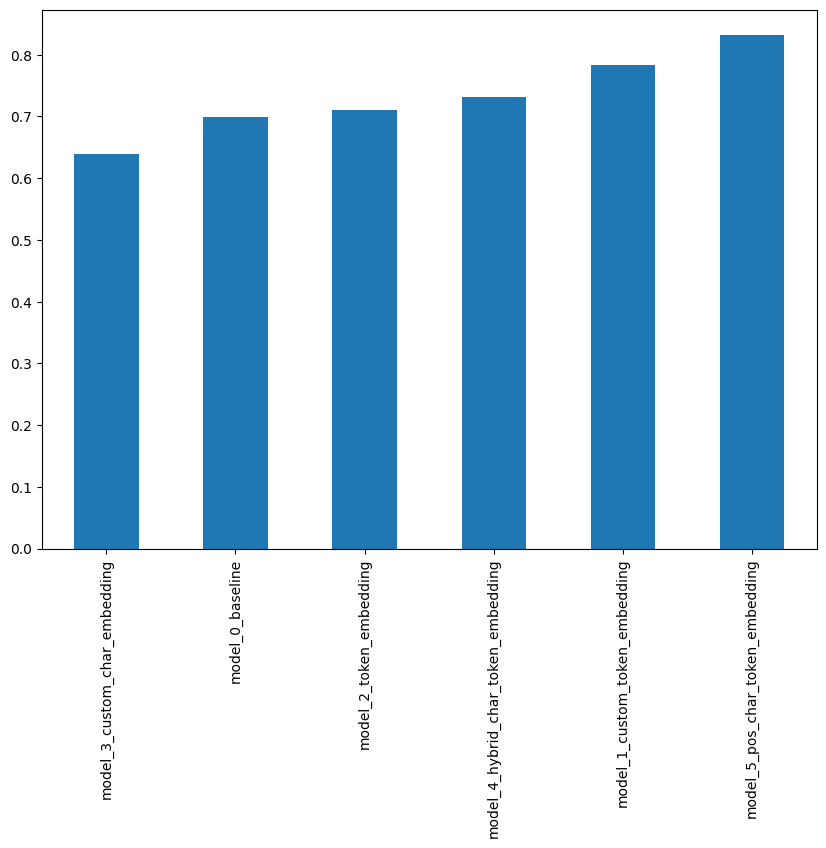

In [134]:
# Sort the model results by f1-score
all_model_results.sort_values("f1", ascending = True)["f1"].plot(kind = "bar", figsize = (10, 7));

## Save and load model

In [140]:
import os
# Ensure the directory exists
save_dir = "/content/Models"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [142]:
model_5.save("/content/Models/skimlit_tribid_model.h5")